# ⬇️ Cell 1 — Install & imports

In [1]:
!pip -q install torch torchvision matplotlib numpy tqdm einops


In [2]:
import math, os, random, copy
from typing import List, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 1337

def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
print('Device:', DEVICE)


Device: cuda


# ⬇️ Cell 2 — Utilities (noise layer, LR schedule, accuracy)

In [3]:
class AddGaussianNoise(nn.Module):
    def __init__(self, beta: float = 0.0):
        super().__init__()
        self.beta = beta
        self.enabled = beta > 0

    def forward(self, x):
        if not self.enabled or self.beta == 0:
            return x
        if not self.training:  # disabled at test-time (per paper)
            return x
        return x + torch.randn_like(x) * self.beta

def geometric_lr_schedule(optimizer, epoch, max_epoch, lr_start=5e-3, lr_end=5e-4):
    # lr_end = lr_start * gamma^(max_epoch-1)
    if max_epoch <= 1: return
    gamma = (lr_end / lr_start) ** (1.0 / (max_epoch - 1))
    for g in optimizer.param_groups:
        g['lr'] = lr_start * (gamma ** epoch)

def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()


# ⬇️ Cell 3 — Datasets (SZT toy + MNIST with augmentation)

In [4]:
def make_szt_toy(n_per_class=2000, d_in=12, seed=SEED):
    g = np.random.default_rng(seed)
    mean0 = np.zeros(d_in)
    mean1 = np.ones(d_in) * 1.5
    cov = np.eye(d_in) * 0.8
    X0 = g.multivariate_normal(mean0, cov, size=n_per_class)
    X1 = g.multivariate_normal(mean1, cov, size=n_per_class)
    X = np.vstack([X0, X1]).astype(np.float32)
    y = np.array([0]*n_per_class + [1]*n_per_class, dtype=np.int64)
    idx = g.permutation(len(X))
    return torch.from_numpy(X[idx]), torch.from_numpy(y[idx])

def get_mnist_loaders(batch_size=32, augment=True, subset_for_speed=None):
    # Appendix B.3: rotations ±10°, shear ±10°, translations ±2 px. :contentReference[oaicite:3]{index=3}
    t_aug = transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(2/28, 2/28), shear=10, scale=(1.0, 1.0)),
        transforms.ToTensor(),
    ])
    t_plain = transforms.ToTensor()

    train = datasets.MNIST(root='./data', train=True, download=True,
                           transform=t_aug if augment else t_plain)
    test  = datasets.MNIST(root='./data', train=False, download=True,
                           transform=t_plain)

    if subset_for_speed is not None:
        train = Subset(train, list(range(subset_for_speed)))
        test  = Subset(test, list(range(min(1000, subset_for_speed))))

    return (
        DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True),
        DataLoader(test,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True),
    )


# ⬇️ Cell 4 — Models (MNIST CNN per Appendix B.3 & SZT FC)

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, beta=0.0):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=5, padding=2)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.Tanh()
        self.noise= AddGaussianNoise(beta=beta)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x, capture=None, tag=None):
        x = self.conv(x); x = self.bn(x); x = self.act(x)
        if capture is not None and tag is not None:
            capture[tag+'_S'] = x.detach()      # pre-noise S_ℓ
        x = self.noise(x)
        x = self.pool(x)
        if capture is not None and tag is not None:
            capture[tag+'_T'] = x.detach()      # post-pool representation (for L1/L2 comparisons)
        return x

class FCBlock(nn.Module):
    def __init__(self, in_f, out_f, beta=0.0):
        super().__init__()
        self.fc  = nn.Linear(in_f, out_f)
        self.bn  = nn.BatchNorm1d(out_f)
        self.act = nn.Tanh()
        self.noise= AddGaussianNoise(beta=beta)

    def forward(self, x, capture=None, tag=None):
        x = self.fc(x); x = self.bn(x); x = self.act(x)
        if capture is not None and tag is not None:
            capture[tag+'_S'] = x.detach()
        x = self.noise(x)
        if capture is not None and tag is not None:
            capture[tag+'_T'] = x.detach()
        return x

class MNISTCNN(nn.Module):
    """
    Appendix B.3 topology: conv -> BN -> tanh -> noise/dropout -> pool (x2), then FC128 (BN,tanh,noise) -> FC10. :contentReference[oaicite:4]{index=4}
    At test-time, noise/dropout are disabled (paper evaluates deterministically).
    """
    def __init__(self, beta=0.0, dropout_p=None):
        super().__init__()
        self.use_dropout = dropout_p is not None and dropout_p > 0
        self.c1 = ConvBlock(1, 16, beta if not self.use_dropout else 0.0)
        self.c2 = ConvBlock(16, 32, beta if not self.use_dropout else 0.0)
        self.flatten = nn.Flatten()
        self.fc1 = FCBlock(32*7*7, 128, beta if not self.use_dropout else 0.0)
        self.fc2 = nn.Linear(128, 10)
        if self.use_dropout:
            self.drop1 = nn.Dropout(p=dropout_p)
            self.drop2 = nn.Dropout(p=dropout_p)
            self.drop3 = nn.Dropout(p=dropout_p)

    def forward(self, x, capture: Optional[dict] = None):
        if self.use_dropout and self.training:
            # dropout positioned where noise would be
            x = self.c1.conv(x); x = self.c1.bn(x); x = self.c1.act(x)
            if capture is not None: capture['L1_S'] = x.detach()
            x = self.drop1(x); x = self.c1.pool(x)
            if capture is not None: capture['L1_T'] = x.detach()

            x = self.c2.conv(x); x = self.c2.bn(x); x = self.c2.act(x)
            if capture is not None: capture['L2_S'] = x.detach()
            x = self.drop2(x); x = self.c2.pool(x)
            if capture is not None: capture['L2_T'] = x.detach()

            x = self.flatten(x)
            x = self.fc1.fc(x); x = self.fc1.bn(x); x = self.fc1.act(x)
            if capture is not None: capture['L3_S'] = x.detach()
            x = self.drop3(x)
            if capture is not None: capture['L3_T'] = x.detach()
            logits = self.fc2(x)
            if capture is not None: capture['L4_T'] = logits.detach()
            return logits

        x = self.c1(x, capture=capture, tag='L1')
        x = self.c2(x, capture=capture, tag='L2')
        x = self.flatten(x)
        x = self.fc1(x, capture=capture, tag='L3')
        logits = self.fc2(x)
        if capture is not None:
            capture['L4_T'] = logits.detach()
        return logits

    def disable_noise_for_eval(self):
        for m in self.modules():
            if isinstance(m, AddGaussianNoise):
                m.enabled = False

# SZT fully-connected model: 12–10–7–5–4–3–2 (β≈0.005 for tanh in Fig. 5(a)). :contentReference[oaicite:5]{index=5}
class MLPBlock(nn.Module):
    def __init__(self, in_f, out_f, beta=0.0, nonlin='tanh'):
        super().__init__()
        self.fc = nn.Linear(in_f, out_f, bias=True)
        self.act = nn.Tanh() if nonlin=='tanh' else (nn.ReLU() if nonlin=='relu' else nn.Identity())
        self.noise = AddGaussianNoise(beta)

    def forward(self, x, capture=None, tag=None):
        x = self.fc(x); x = self.act(x)
        if capture is not None and tag is not None:
            capture[tag+'_S'] = x.detach()
        x = self.noise(x)
        if capture is not None and tag is not None:
            capture[tag+'_T'] = x.detach()
        return x

class SZTFC(nn.Module):
    def __init__(self, dims=(12,10,7,5,4,3,2), beta=0.005, nonlin='tanh'):
        super().__init__()
        sizes = list(dims)
        self.blocks = nn.ModuleList([MLPBlock(sizes[i], sizes[i+1], beta=beta, nonlin=nonlin) for i in range(len(sizes)-1)])
        self.head = nn.Linear(sizes[-1], 2)

    def forward(self, x, capture=None):
        for i, blk in enumerate(self.blocks, start=1):
            x = blk(x, capture=capture, tag=f'L{i}')
        logits = self.head(x)
        if capture is not None:
            capture['Lout_T'] = logits.detach()
        return logits


# ⬇️ Cell 5 — Train/eval loops

In [6]:
def train_one_epoch(model, opt, loader, epoch, max_epoch, lr_start=5e-3, lr_end=5e-4):
    model.train()
    total_loss = total_acc = n = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * y.size(0)
        total_acc  += (logits.argmax(1) == y).sum().item()
        n += y.size(0)
    geometric_lr_schedule(opt, epoch, max_epoch, lr_start, lr_end)
    return total_loss/n, total_acc/n

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    if hasattr(model, 'disable_noise_for_eval'):
        model.disable_noise_for_eval()  # per paper
    total_loss = total_acc = n = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        total_loss += loss.item() * y.size(0)
        total_acc  += (logits.argmax(1) == y).sum().item()
        n += y.size(0)
    return total_loss/n, total_acc/n


# ⬇️ Cell 6 — SP estimator (Gaussian-mixture entropy via MC, then $I_{SP}$ )

In [7]:
# Monte-Carlo computation of h(g) for g = (1/n) Σ_i N(μ_i, β^2 I) — Appendix C.5 (Eqs. 11–12). :contentReference[oaicite:6]{index=6}
# --- PATCH: numerically-stable, tile-safe mixture entropy ---
def gaussian_mixture_entropy(mu: torch.Tensor, beta: float, n_mc: int = 64, inner_chunk: int = 1024) -> float:
    """
    Estimate h(g) for g = (1/n) sum_i N(μ_i, β^2 I) via MC.
    This version streams log-sum-exp across tiles, avoiding shape mismatches.
    """
    mu = mu.to(DEVICE).double()
    n, d = mu.shape
    const = -d * math.log(beta * math.sqrt(2*math.pi)) - math.log(n)

    # Draw noise and form t_ij = μ_i + z_ij
    z = torch.randn(n, n_mc, d, device=mu.device, dtype=mu.dtype) * beta
    t = (mu[:, None, :] + z).reshape(-1, d)  # (n*n_mc, d)

    out = torch.empty(t.shape[0], device=mu.device, dtype=mu.dtype)
    two_beta2 = 2 * (beta**2)
    mu_sq = (mu**2).sum(dim=1)  # (n,)

    B = 2048  # batch over (i,j) samples
    for start in range(0, t.shape[0], B):
        tb = t[start:start+B]                        # (B,d)
        tb_sq = (tb**2).sum(dim=1, keepdim=True)     # (B,1)

        # Streamed log-sum-exp over k tiles: keep a vector (B,)
        lse_vec = torch.full((tb.shape[0],), float('-inf'), device=mu.device, dtype=mu.dtype)

        for k0 in range(0, n, inner_chunk):
            mk    = mu[k0:k0+inner_chunk]           # (K,d)
            mk_sq = mu_sq[k0:k0+inner_chunk]        # (K,)
            # ||t - μ_k||^2 = ||t||^2 + ||μ_k||^2 - 2 t·μ_k
            d2 = tb_sq + mk_sq.unsqueeze(0) - 2.0 * (tb @ mk.T)  # (B,K)
            part = (-d2 / two_beta2)                                # (B,K)

            # log-sum-exp across the K columns of this tile -> (B,)
            tile_lse = part.logsumexp(dim=1)

            # combine tiles in log domain: log(exp(lse_vec) + exp(tile_lse))
            lse_vec = torch.logaddexp(lse_vec, tile_lse)

        out[start:start+B] = const + lse_vec

    # h(g) = - E[log g(V)]
    return float(-out.mean().item())


@torch.no_grad()
def sp_mutual_information(uncond_mu: torch.Tensor,
                          cond_mus: List[torch.Tensor],
                          beta: float, n_mc: int = 64) -> float:
    """
    Î_SP = h( (1/n) Σ δ_{μ_i} * N(0,β^2 I) ) - (1/M) Σ_x h( (1/m_x) Σ δ_{μ_{x,j}} * N(0,β^2 I) )
    (Matches Section 3.1 Eq. (1).) :contentReference[oaicite:7]{index=7}
    """
    h_un = gaussian_mixture_entropy(uncond_mu, beta=beta, n_mc=n_mc)
    h_cond_list = [gaussian_mixture_entropy(mu_x, beta=beta, n_mc=n_mc) for mu_x in cond_mus]
    return h_un - float(np.mean(h_cond_list))

@torch.no_grad()
def collect_unconditional_S(model, loader, layer_tag='L3', max_samples=2000):
    model.eval()
    feats, n_collected = [], 0
    for x, _ in loader:
        cap = {}
        _ = model(x.to(DEVICE), capture=cap)
        s = cap[layer_tag + '_S'].flatten(start_dim=1)
        feats.append(s.cpu())
        n_collected += s.shape[0]
        if n_collected >= max_samples: break
    return torch.cat(feats, dim=0)[:max_samples]

@torch.no_grad()
def collect_conditional_S(model, x, layer_tag='L3', m=32):
    # enable training to sample fresh noise in lower layers
    model.train()
    Ss = []
    for _ in range(m):
        cap = {}
        _ = model(x.to(DEVICE), capture=cap)
        s = cap[layer_tag + '_S'].flatten(start_dim=1)
        Ss.append(s.cpu())
    return torch.cat(Ss, dim=0)


# ⬇️ Cell 7 — SZT toy experiment (MI vs epochs + 3D scatter for L5)

Training SZT:   0%|          | 0/60 [00:00<?, ?it/s]

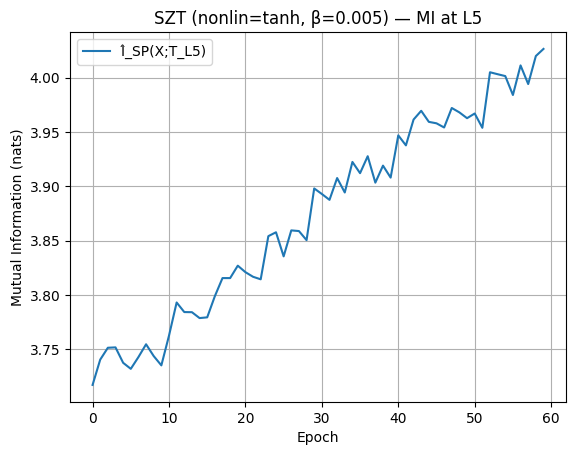

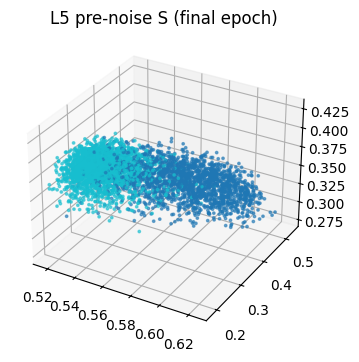

In [8]:
# Quick demo config (increase epochs for fuller curves)
epochs = 60
beta   = 0.005      # Fig. 5(a) tanh SZT. :contentReference[oaicite:8]{index=8}
nonlin = 'tanh'
batch_size = 64
lr_start, lr_end = 5e-3, 5e-4

# Data
X, y = make_szt_toy(n_per_class=2000, d_in=12, seed=SEED)
train_ds = torch.utils.data.TensorDataset(X, y)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Model
model = SZTFC(beta=beta, nonlin=nonlin).to(DEVICE)
opt = torch.optim.SGD(model.parameters(), lr=lr_start, momentum=0.0)

mi_hist, train_loss_hist = [], []
for ep in tqdm(range(epochs), desc="Training SZT"):
    tl, ta = train_one_epoch(model, opt, train_loader, ep, epochs, lr_start, lr_end)
    train_loss_hist.append(tl)

    # MI at layer L5 (dimension 3) to visualize clustering clearly
    with torch.no_grad():
        cap = {}; _ = model(X.to(DEVICE), capture=cap)
        S = cap['L5_S'].cpu().flatten(start_dim=1)
        # Subsample M inputs and do m draws each for S|X
        M, m = 64, 16
        idx = torch.randperm(len(X))[:M]
        cond_list = [collect_conditional_S(model, X[i:i+1], layer_tag='L5', m=m) for i in idx]

    I_hat = sp_mutual_information(S, cond_list, beta=beta, n_mc=32)
    mi_hist.append(I_hat)

plt.figure(); plt.plot(mi_hist, label='Î_SP(X;T_L5)')
plt.xlabel('Epoch'); plt.ylabel('Mutual Information (nats)'); plt.grid(True); plt.legend()
plt.title(f'SZT (nonlin={nonlin}, β={beta}) — MI at L5'); plt.show()

# 3D scatter snapshots of L5 pre-noise S (choose a few epochs; showing current weights)
with torch.no_grad():
    cap = {}; _ = model(X.to(DEVICE), capture=cap)
    S_now = cap['L5_S'].cpu().numpy(); yy = y.numpy()

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S_now[:,0], S_now[:,1], S_now[:,2], c=yy, s=3, alpha=0.6, cmap='tab10')
ax.set_title('L5 pre-noise S (final epoch)'); plt.show()


# ⬇️ Cell 8 — MNIST CNN: deterministic / noisy / dropout training

In [9]:
# To fully match the paper use epochs=128; here we default smaller for speed.
mnist_epochs  = 5            # change to 128 for full run
batch_size    = 32
subset_speed  = 20000        # None for full MNIST; small subset for Colab speed

train_loader, test_loader = get_mnist_loaders(batch_size=batch_size, augment=True, subset_for_speed=subset_speed)

# Deterministic baseline
det_model = MNISTCNN(beta=0.0, dropout_p=None).to(DEVICE)
det_opt   = torch.optim.SGD(det_model.parameters(), lr=5e-3, momentum=0.0)
for ep in tqdm(range(mnist_epochs), desc="Deterministic MNIST"):
    train_one_epoch(det_model, det_opt, train_loader, ep, mnist_epochs)
vl, va = evaluate(det_model, test_loader)
print("Deterministic test acc:", va)

# Noisy model(s) (pick a beta you like)
beta_vals = [0.05]  # extend with [0.1, 0.2, 0.5] if desired
noisy_runs = []
for beta in beta_vals:
    model = MNISTCNN(beta=beta, dropout_p=None).to(DEVICE)
    opt   = torch.optim.SGD(model.parameters(), lr=5e-3, momentum=0.0)
    for ep in tqdm(range(mnist_epochs), desc=f"Noisy β={beta}"):
        train_one_epoch(model, opt, train_loader, ep, mnist_epochs)
    vl, va = evaluate(model, test_loader)
    print(f"Noisy β={beta} test acc:", va)
    noisy_runs.append((beta, model))

# Dropout version (p=0.2)
drop_model = MNISTCNN(beta=0.0, dropout_p=0.2).to(DEVICE)
drop_opt   = torch.optim.SGD(drop_model.parameters(), lr=5e-3, momentum=0.0)
for ep in tqdm(range(mnist_epochs), desc="Dropout p=0.2"):
    train_one_epoch(drop_model, drop_opt, train_loader, ep, mnist_epochs)
vl, va = evaluate(drop_model, test_loader)
print("Dropout test acc:", va)


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.86MB/s]


Deterministic MNIST:   0%|          | 0/5 [00:00<?, ?it/s]

Deterministic test acc: 0.982


Noisy β=0.05:   0%|          | 0/5 [00:00<?, ?it/s]

Noisy β=0.05 test acc: 0.972


Dropout p=0.2:   0%|          | 0/5 [00:00<?, ?it/s]

Dropout test acc: 0.835


# ⬇️ Cell 9 — Cosine-similarity histograms vs deterministic (Fig. 3 style)

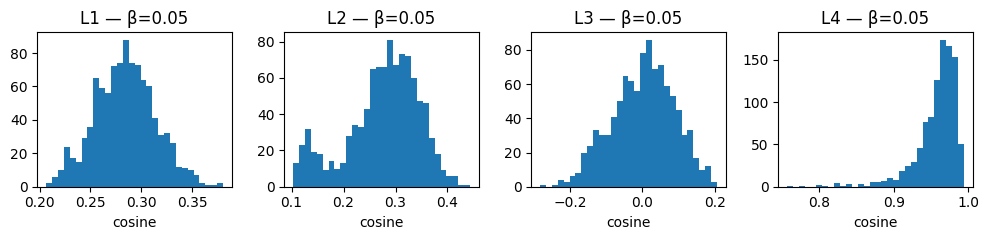

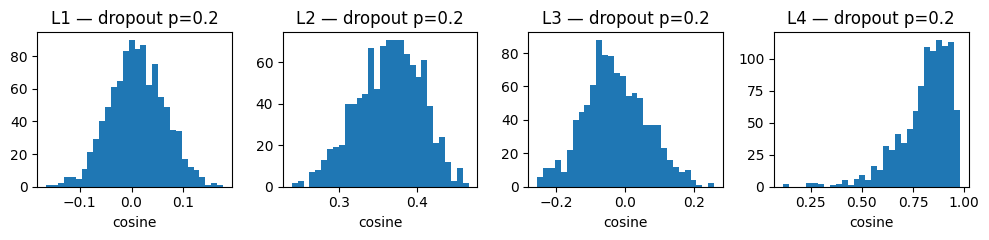

In [10]:
@torch.no_grad()
def collect_layer_T(model, loader, layer_tag='L3', max_samples=5000):
    model.eval()
    if hasattr(model, 'disable_noise_for_eval'): model.disable_noise_for_eval()
    feats, n_collected = [], 0
    for x, _ in loader:
        cap = {}; _ = model(x.to(DEVICE), capture=cap)
        t = cap[layer_tag + '_T'].flatten(start_dim=1).cpu()
        feats.append(t)
        n_collected += t.shape[0]
        if n_collected >= max_samples: break
    return torch.cat(feats, dim=0)[:max_samples]

def cosine_sim(A, B):
    A = F.normalize(A, p=2, dim=1)
    B = F.normalize(B, p=2, dim=1)
    return (A*B).sum(dim=1).cpu().numpy()

det_feats = {tag: collect_layer_T(det_model, test_loader, tag) for tag in ['L1','L2','L3','L4']}

for beta, model in noisy_runs + [("dropout", drop_model)]:
    lab = f"β={beta}" if beta != "dropout" else "dropout p=0.2"
    plt.figure(figsize=(10,2.5))
    for i, tag in enumerate(['L1','L2','L3','L4'], start=1):
        m_feats = collect_layer_T(model, test_loader, tag)
        sims = cosine_sim(det_feats[tag], m_feats)   # sample-aligned
        plt.subplot(1,4,i); plt.hist(sims, bins=30)
        plt.title(f"{tag} — {lab}"); plt.xlabel("cosine")
    plt.tight_layout(); plt.show()


# ⬇️ Cell 10 — Binned entropy $H(Bin(T_l))$ (two bins) + unit-level trend

In [11]:
def bin_entropy_two_bins_layer(T: torch.Tensor) -> float:
    # Two bins: [-∞,0], (0,∞] elementwise; treat each sample’s bin-vector as a symbol.
    X = T.detach().cpu()
    bits = (X > 0).numpy().astype(np.uint8)
    # Pack each bit-vector into a bytestring key for counting
    strs = [''.join(map(chr, b.tobytes())) for b in bits]
    from collections import Counter
    cnt = Counter(strs); N = len(strs)
    ps = np.array([c/N for c in cnt.values()], dtype=np.float64)
    return float(-(ps * np.log(ps + 1e-12)).sum())  # nats

@torch.no_grad()
def H_bin_over_layers(model, loader):
    Ts = {tag: collect_layer_T(model, loader, tag, max_samples=3000) for tag in ['L1','L2','L3','L4']}
    Hs = {tag: bin_entropy_two_bins_layer(Ts[tag]) for tag in Ts}
    return Hs

print("H(Bin(Tℓ)) for deterministic (demo subset):")
print(H_bin_over_layers(det_model, test_loader))
# Fig. 7 inset in paper uses two bins and shows near-injectivity (≈ ln(10000)) across layers/epochs. :contentReference[oaicite:9]{index=9}


H(Bin(Tℓ)) for deterministic (demo subset):
{'L1': 6.9077552779821385, 'L2': 6.9077552779821385, 'L3': 6.9077552779821385, 'L4': 4.918076567941197}


# ⬇️ Cell 11 — Within-/between-class pairwise distance histograms (Fig. 8 style)

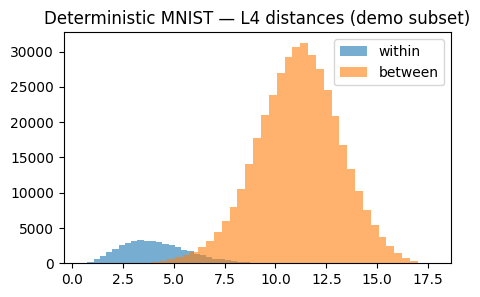

In [12]:
@torch.no_grad()
def pairwise_histograms(model, loader, layer_tag='L3', sample_per_class=150):
    model.eval()
    if hasattr(model,'disable_noise_for_eval'): model.disable_noise_for_eval()
    feats, labels, counts = [], [], {i:0 for i in range(10)}
    for x, y in loader:
        x = x.to(DEVICE); y = y.cpu()
        cap = {}; _ = model(x, capture=cap)
        t = cap[layer_tag + '_T'].flatten(start_dim=1).cpu()
        for i in range(len(y)):
            c = int(y[i])
            if counts[c] < sample_per_class:
                feats.append(t[i:i+1]); labels.append(c); counts[c]+=1
        if all(counts[c]>=sample_per_class for c in counts): break
    X = torch.cat(feats, dim=0).numpy()
    y = np.array(labels)
    from sklearn.metrics import pairwise_distances
    D = pairwise_distances(X, metric='euclidean')
    tri = np.triu_indices_from(D, k=1)
    y_i = np.broadcast_to(y[:,None], D.shape)[tri]
    y_j = np.broadcast_to(y[None,:], D.shape)[tri]
    W = D[tri][y_i==y_j]
    B = D[tri][y_i!=y_j]
    return W, B

W, B = pairwise_histograms(det_model, test_loader, layer_tag='L4', sample_per_class=100)
plt.figure(figsize=(5,3))
plt.hist(W, bins=40, alpha=0.6, label='within')
plt.hist(B, bins=40, alpha=0.6, label='between')
plt.legend(); plt.title("Deterministic MNIST — L4 distances (demo subset)"); plt.show()
# See Fig. 8 narrative in paper. :contentReference[oaicite:10]{index=10}


# Now new ones :

In [13]:
# --- BN-safe internal-noise sampling + robust conditional collector ---

from contextlib import contextmanager

@contextmanager
def noise_only_train(model):
    """
    Enable *only* AddGaussianNoise modules to 'train' (so they inject noise),
    keep BatchNorm layers in eval, and keep everything else in eval.
    Restores original training states on exit.
    """
    # snapshot original training flags
    orig = {}
    for m in model.modules():
        orig[m] = m.training

    # put whole model in eval by default
    model.eval()

    # selectively toggle submodules
    for m in model.modules():
        # Keep BN layers in eval to avoid batch-size=1 errors
        if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
            m.eval()
        # Force only noise layers to train, so they add noise even with single-sample batches
        elif isinstance(m, AddGaussianNoise):
            m.enabled = True
            m.train()

    try:
        yield
    finally:
        # restore original states
        for m, was_training in orig.items():
            if was_training:
                m.train()
            else:
                m.eval()

@torch.no_grad()
def collect_conditional_S(
    model, x, layer_tag='L3', m=32, use_internal_noise=False
):
    """
    Collect S_ell | X=x:
      - If use_internal_noise: enable noise-only-train (BN stays eval) and resample m times.
      - Else (deterministic / virtual-noise SP): single eval pass, then repeat S m times.
    """
    if use_internal_noise:
        Ss = []
        with noise_only_train(model):
            for _ in range(m):
                cap = {}
                _ = model(x.to(DEVICE), capture=cap)
                s = cap[layer_tag + '_S'].flatten(start_dim=1)
                Ss.append(s.cpu())
        return torch.cat(Ss, dim=0)
    else:
        # Deterministic pass; repeat m times (δ_{μ} * N is handled by SP convolution)
        model.eval()
        cap = {}
        _ = model(x.to(DEVICE), capture=cap)
        s = cap[layer_tag + '_S'].flatten(start_dim=1).cpu()
        return s.repeat(m, 1)

def _infer_beta_from_model(model):
    for m in model.modules():
        if isinstance(m, AddGaussianNoise) and getattr(m, "beta", 0.0) and m.beta > 0:
            return float(m.beta)
    return None

@torch.no_grad()
def estimate_mi_with_noisy_inputs(
    model,
    clean_loader,
    layer_tag='auto',
    preferred_dim=None,
    sigma_in=0.2,
    M=64, m=16, n_mc=32,
    max_uncond=2000,
    clip=None,
    beta_override=None,
    beta_probe=0.05
):
    """
    I( X~ ; T_ell ) with X~ = X + N(0, sigma_in^2 I).
    - Auto-picks layer_tag if requested.
    - Uses model β if available; else beta_override; else beta_probe (virtual noise).
    - BN layers remain eval even when resampling internal noise.
    """
    # layer discovery
    if layer_tag == 'auto':
        x0, _ = next(iter(clean_loader))
        tag_dims = _discover_tags_and_dims(model, x0)
        if preferred_dim is not None:
            # exact or nearest match
            layer_tag = min(tag_dims.items(), key=lambda kv: abs(kv[1]-preferred_dim))[0]
        else:
            layer_tag = max(tag_dims.keys(), key=lambda t: int(''.join(filter(str.isdigit, t)) or 0))
        print(f"[layer] Using layer_tag='{layer_tag}'")

    # choose β (for SP convolution)
    beta_internal = _infer_beta_from_model(model)
    if beta_override is not None and beta_override > 0:
        beta = float(beta_override)
        print(f"[SP] Using beta_override={beta:.4g}")
        use_internal_noise = False  # stick to virtual-noise interpretation
    elif beta_internal is not None and beta_internal > 0:
        beta = beta_internal
        print(f"[SP] Using model's internal beta={beta:.4g}")
        use_internal_noise = True   # resample S|X via internal noise
    else:
        beta = float(beta_probe)
        print(f"[SP] No internal Gaussian noise. Using beta_probe={beta:.4g} (virtual layer noise).")
        use_internal_noise = False  # deterministic conditionals

    # --- Unconditional S_ell with NOISY inputs (BN eval) ---
    def add_input_noise(x, s, clip=None):
        xn = x + s * torch.randn_like(x)
        if clip is not None:
            lo, hi = clip; xn = torch.clamp(xn, lo, hi)
        return xn

    feats = []
    n_collected = 0
    model.eval()
    for x, _ in clean_loader:
        x = add_input_noise(x, sigma_in, clip)
        cap = {}
        _ = model(x.to(DEVICE), capture=cap)
        s = cap[layer_tag + '_S'].flatten(start_dim=1).cpu()
        feats.append(s)
        n_collected += s.shape[0]
        if n_collected >= max_uncond:
            break
    S_un = torch.cat(feats, dim=0)[:max_uncond]

    # --- Conditional S_ell | X~=x~ ---
    cond_list, picked = [], 0
    for x, _ in clean_loader:
        x_noisy = add_input_noise(x, sigma_in, clip)
        for i in range(x_noisy.size(0)):
            mu_x = collect_conditional_S(
                model, x_noisy[i:i+1], layer_tag=layer_tag, m=m, use_internal_noise=use_internal_noise
            )
            cond_list.append(mu_x)
            picked += 1
            if picked >= M: break
        if picked >= M: break

    # --- SP MI ---
    I_hat = sp_mutual_information(S_un, cond_list, beta=beta, n_mc=n_mc)
    return I_hat


In [14]:
# --- Robust noisy-input MI with auto layer-tag discovery ---

def add_input_noise(x, sigma, clip=None):
    xn = x + sigma * torch.randn_like(x)
    if clip is not None:
        lo, hi = clip
        xn = torch.clamp(xn, lo, hi)
    return xn

def noisy_batch_iter(loader, sigma_in, clip=None):
    for x, y in loader:
        yield add_input_noise(x, sigma_in, clip), y

def _infer_beta_from_model(model):
    for m in model.modules():
        if isinstance(m, AddGaussianNoise):
            if getattr(m, "beta", 0.0) and m.beta > 0:
                return float(m.beta)
    return None

@torch.no_grad()
def _discover_tags_and_dims(model, sample_x):
    """Return dict: tag -> flattened S-dimension, using a single forward pass."""
    cap = {}
    _ = model(sample_x.to(DEVICE), capture=cap)
    tags = {}
    for k, v in cap.items():
        if k.endswith('_S'):
            tag = k[:-2]  # strip '_S'
            tags[tag] = v.flatten(start_dim=1).shape[1]
    return tags  # e.g., {'L1': 16*14*14, 'L2': 32*7*7, 'L3': 128, ...} or SZT dims

def _pick_layer_tag(model, clean_loader, preferred_dim=None, fallback_deepest=True):
    x0, _ = next(iter(clean_loader))
    tag_dims = _discover_tags_and_dims(model, x0)
    if not tag_dims:
        raise RuntimeError("No capture tags found. Ensure you pass capture=cap to the model forward (already done in helpers).")
    if preferred_dim is not None:
        # exact match first
        for t, d in tag_dims.items():
            if d == preferred_dim:
                return t
        # nearest (optional): choose tag with dim closest to preferred
        nearest = min(tag_dims.items(), key=lambda kv: abs(kv[1] - preferred_dim))[0]
        return nearest
    if fallback_deepest:
        # choose numerically deepest tag like 'L6' > 'L5'
        return max(tag_dims.keys(), key=lambda t: int(''.join(filter(str.isdigit, t)) or 0))
    # else just return the first sorted
    return sorted(tag_dims.keys(), key=lambda t: int(''.join(filter(str.isdigit, t)) or 0))[0]

@torch.no_grad()
def estimate_mi_with_noisy_inputs(
    model,
    clean_loader,
    layer_tag='auto',     # 'auto' or explicit like 'L3'
    preferred_dim=None,   # e.g., 3 for SZT's 3D layer
    sigma_in=0.2,
    M=64, m=16, n_mc=32,
    max_uncond=2000,
    clip=None,
    beta_override=None,
    beta_probe=0.05       # used if model lacks internal Gaussian noise
):
    """
    I( X~ ; T_ell ) with X~ = X + N(0, sigma_in^2 I).
    - If 'layer_tag' == 'auto', we try to pick a tag that matches preferred_dim (if given) or the deepest layer.
    - Uses model's internal β if present; otherwise uses beta_override, else beta_probe.
    """
    # Pick layer tag if auto
    if layer_tag == 'auto':
        layer_tag = _pick_layer_tag(model, clean_loader, preferred_dim=preferred_dim, fallback_deepest=True)
        print(f"[layer] Using layer_tag='{layer_tag}' (preferred_dim={preferred_dim})")

    # Choose β for SP
    beta_internal = _infer_beta_from_model(model)
    if beta_override is not None and beta_override > 0:
        beta = float(beta_override)
        print(f"[SP] Using beta_override={beta:.4g}")
    elif beta_internal is not None and beta_internal > 0:
        beta = beta_internal
        print(f"[SP] Using model's internal beta={beta:.4g}")
    else:
        beta = float(beta_probe)
        print(f"[SP] No internal Gaussian noise. Using beta_probe={beta:.4g} (virtual layer noise).")

    # --- Unconditional S_ell with NOISY inputs ---
    noisy_iter = noisy_batch_iter(clean_loader, sigma_in=sigma_in, clip=clip)
    S_un = collect_unconditional_S(model, noisy_iter, layer_tag=layer_tag, max_samples=max_uncond)

    # --- Conditional S_ell | X~=x~ ---
    cond_list = []
    picked = 0
    for x, _ in clean_loader:
        x_noisy = add_input_noise(x, sigma_in, clip)
        for i in range(x_noisy.size(0)):
            mu_x = collect_conditional_S(model, x_noisy[i:i+1], layer_tag=layer_tag, m=m)
            cond_list.append(mu_x)
            picked += 1
            if picked >= M: break
        if picked >= M: break

    # --- SP MI ---
    I_hat = sp_mutual_information(S_un, cond_list, beta=beta, n_mc=n_mc)
    return I_hat

# -------------------- Examples --------------------

# A) SZT toy — auto-pick the 3D layer (preferred_dim=3). If your SZT dims differ, it will choose the nearest or deepest.
szt_sigma_in = 0.30
I_szt = estimate_mi_with_noisy_inputs(
    model,                 # <- your SZTFC instance
    train_loader,
    layer_tag='auto',
    preferred_dim=3,       # pick the 3-D block if present
    sigma_in=szt_sigma_in,
    M=64, m=16, n_mc=32,
    max_uncond=2000,
    clip=None,
    beta_probe=0.005       # matches SZT β scale
)
print(f"SZT — I( X̃ ; T_{'auto'} ) with σ_in={szt_sigma_in}: {I_szt:.4f} nats")

# B) MNIST — explicit L3 (feature layer). If your active model is the noisy one, its β will be used automatically.
mnist_sigma_in = 0.20
active_mnist_model = mnist_noisy if 'mnist_noisy' in globals() else det_model
I_mnist = estimate_mi_with_noisy_inputs(
    active_mnist_model,
    test_loader,
    layer_tag='L3',
    sigma_in=mnist_sigma_in,
    M=50, m=16, n_mc=16,
    max_uncond=800,
    clip=(0.0, 1.0),
    beta_probe=0.05
)
print(f"MNIST — I( X̃ ; T_L3 ) with σ_in={mnist_sigma_in}: {I_mnist:.4f} nats")


[layer] Using layer_tag='L3' (preferred_dim=3)
[SP] No internal Gaussian noise. Using beta_probe=0.005 (virtual layer noise).
SZT — I( X̃ ; T_auto ) with σ_in=0.3: 7.6427 nats
[SP] No internal Gaussian noise. Using beta_probe=0.05 (virtual layer noise).
MNIST — I( X̃ ; T_L3 ) with σ_in=0.2: 6.7812 nats


In [15]:
# === Report MI for NOISELESS (σ=0) and NOISY (σ>0) inputs — SEPARATE TABLES, no plots/saving ===
# Requires you already defined:
#   - estimate_mi_with_noisy_inputs(...)
# And you have (if you want these to run):
#   - SZT:    model, train_loader
#   - MNIST:  det_model or mnist_noisy, and test_loader

import math
import io
from contextlib import redirect_stdout
import pandas as pd

def _mi_quiet(model, loader, *, layer_tag, preferred_dim, sigma_in, clip, beta_probe, beta_override,
              M, m, n_mc, max_uncond):
    """Call the estimator while silencing internal prints for clean output."""
    buf = io.StringIO()
    with redirect_stdout(buf):
        I = estimate_mi_with_noisy_inputs(
            model,
            loader,
            layer_tag=layer_tag,
            preferred_dim=preferred_dim,
            sigma_in=float(sigma_in),
            M=M, m=m, n_mc=n_mc,
            max_uncond=max_uncond,
            clip=clip,
            beta_probe=beta_probe,
            beta_override=beta_override
        )
    return I

def report_noiseless_and_noisy(
    name,
    model,
    loader,
    *,
    layer_tag='auto',
    preferred_dim=None,
    noisy_sigmas=(0.1, 0.2, 0.3),
    clip=None,
    beta_probe=0.05,
    beta_override=None,
    M=64, m=16, n_mc=16, max_uncond=1000
):
    # NOISELESS (σ=0)
    I0 = _mi_quiet(
        model, loader,
        layer_tag=layer_tag, preferred_dim=preferred_dim,
        sigma_in=0.0, clip=clip,
        beta_probe=beta_probe, beta_override=beta_override,
        M=M, m=m, n_mc=n_mc, max_uncond=max_uncond
    )
    df_noiseless = pd.DataFrame([{
        "sigma_in": 0.0,
        "I_nats": I0,
        "I_bits": I0 / math.log(2),
    }])

    # NOISY (σ>0)
    rows_noisy = []
    for s in noisy_sigmas:
        I = _mi_quiet(
            model, loader,
            layer_tag=layer_tag, preferred_dim=preferred_dim,
            sigma_in=s, clip=clip,
            beta_probe=beta_probe, beta_override=beta_override,
            M=M, m=m, n_mc=n_mc, max_uncond=max_uncond
        )
        rows_noisy.append({"sigma_in": float(s), "I_nats": I, "I_bits": I / math.log(2)})
    df_noisy = pd.DataFrame(rows_noisy).sort_values("sigma_in").reset_index(drop=True)

    # PRINT (separate, no comparisons)
    print(f"\n=== {name} — NOISELESS INPUT (σ=0) ===")
    print(df_noiseless.to_string(index=False))
    print(f"\n=== {name} — NOISY INPUTS (σ>0) ===")
    print(df_noisy.to_string(index=False))

# ------------------- RUN (only if variables exist) -------------------

# SZT (uses your SZT model + train_loader; prefers the 3-D layer if present)
if 'model' in globals() and 'train_loader' in globals():
    report_noiseless_and_noisy(
        name="SZT",
        model=model,
        loader=train_loader,
        layer_tag='auto',
        preferred_dim=3,
        noisy_sigmas=(0.1, 0.2, 0.3, 0.4),
        clip=None,
        beta_probe=0.005,
        beta_override=None,
        M=64, m=16, n_mc=16, max_uncond=2000
    )

# MNIST (uses your noisy MNIST model if defined, otherwise deterministic; reports layer L3)
if 'test_loader' in globals() and ('mnist_noisy' in globals() or 'det_model' in globals()):
    active_mnist_model = mnist_noisy if 'mnist_noisy' in globals() else det_model
    report_noiseless_and_noisy(
        name="MNIST_L3",
        model=active_mnist_model,
        loader=test_loader,
        layer_tag='L3',
        preferred_dim=None,
        noisy_sigmas=(0.05, 0.1, 0.2, 0.3),
        clip=(0.0, 1.0),
        beta_probe=0.05,
        beta_override=None,
        M=50, m=16, n_mc=16, max_uncond=800
    )



=== SZT — NOISELESS INPUT (σ=0) ===
 sigma_in   I_nats   I_bits
      0.0 7.603727 10.96986

=== SZT — NOISY INPUTS (σ>0) ===
 sigma_in   I_nats    I_bits
      0.1 7.490273 10.806179
      0.2 7.662813 11.055103
      0.3 7.551099 10.893933
      0.4 7.579171 10.934432

=== MNIST_L3 — NOISELESS INPUT (σ=0) ===
 sigma_in   I_nats   I_bits
      0.0 6.658022 9.605495

=== MNIST_L3 — NOISY INPUTS (σ>0) ===
 sigma_in   I_nats   I_bits
     0.05 6.834194 9.859658
     0.10 6.725748 9.703203
     0.20 6.779210 9.780333
     0.30 6.737847 9.720659


In [16]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import wasserstein_distance
from sklearn.metrics import pairwise_distances
from torch.distributions import Normal
from torch import nn
import math
import pandas as pd

# === Helpers ===

def _as_float4d(x):
    """
    Ensure x is float tensor with 4D shape [B,C,H,W].
    Keeps device unchanged; converts dtype to float32 if needed.
    """
    if x.dim() != 4:
        raise ValueError(f"Expected 4D [B,C,H,W], got {x.dim()}D tensor with shape {tuple(x.shape)}")
    if not x.is_floating_point():
        x = x.float()
    return x

# === Updated Perturbation functions to maintain 4D shape & dtype ===

def kl_perturb(x, max_distance, model, beta=0.005):
    """
    Perturb each sample in `x` by a maximum KL distance (approximated with Gaussian noise).
    x: 4D tensor of shape [batch_size, channels, height, width]
    """
    x = _as_float4d(x)
    # Use a stable Normal parameterization in float; avoid integer loc issues
    scale = torch.full_like(x, fill_value=beta)
    dist = Normal(loc=x, scale=scale)
    noise = dist.sample()  # same shape & dtype as x
    perturbed_x = x + noise * max_distance

    # Optional: clamp if your inputs are in [0,1]
    # perturbed_x = perturbed_x.clamp(0.0, 1.0)

    assert perturbed_x.dim() == 4, f"Expected 4D, got {perturbed_x.dim()}D tensor"
    return perturbed_x

def wasserstein_perturb(x, max_distance, model):
    """
    Perturb each sample in `x` by a maximum Wasserstein distance.
    x: 4D tensor of shape [batch_size, channels, height, width]
    """
    x = _as_float4d(x)
    noise = torch.randn_like(x) * max_distance
    perturbed_x = x + noise

    # Optional: clamp if your inputs are in [0,1]
    # perturbed_x = perturbed_x.clamp(0.0, 1.0)

    assert perturbed_x.dim() == 4, f"Expected 4D, got {perturbed_x.dim()}D tensor"
    return perturbed_x

def tv_perturb(x, max_distance, model):
    """
    Perturb each sample in `x` by a maximum Total Variation (TV) distance.
    x: 4D tensor of shape [batch_size, channels, height, width]
    """
    x = _as_float4d(x)
    noise = torch.sign(torch.randn_like(x)) * max_distance
    perturbed_x = x + noise

    # Optional: clamp if your inputs are in [0,1]
    # perturbed_x = perturbed_x.clamp(0.0, 1.0)

    assert perturbed_x.dim() == 4, f"Expected 4D, got {perturbed_x.dim()}D tensor"
    return perturbed_x

# === Information Flow Estimator (SP Estimator) ===

def estimate_mi_for_perturbed_data(model, perturbed_loader, layer_tag='auto', preferred_dim=None,
                                    sigma_in=0.2, M=64, m=16, n_mc=16, max_uncond=1000,
                                    clip=None, beta_probe=0.05, beta_override=None):
    """Estimates information flow for perturbed data using the SP estimator."""
    rows = []
    I_hat = estimate_mi_with_noisy_inputs(
        model,
        perturbed_loader,
        layer_tag=layer_tag,
        preferred_dim=preferred_dim,
        sigma_in=sigma_in,
        M=M, m=m, n_mc=n_mc,
        max_uncond=max_uncond,
        clip=clip,
        beta_probe=beta_probe,
        beta_override=beta_override
    )
    rows.append({"sigma_in": sigma_in, "I_nats": I_hat, "I_bits": I_hat / math.log(2)})
    return rows

# === Main function to perturb data and estimate information flow ===

def perturb_and_estimate(
    model, loader, distances=['KL', 'Wasserstein', 'TV'], max_distances=[0.1, 0.2, 0.3],
    layer_tag='auto', preferred_dim=None, clip=None, beta_probe=0.05, beta_override=None,
    M=64, m=16, n_mc=16, max_uncond=1000):

    results = []

    for dist in distances:
        print(f"\nEstimating Information Flow for Perturbed Data (Distance: {dist})")

        for max_distance in max_distances:
            print(f"\n--- Perturbing with maximum {dist} distance: {max_distance} ---")

            all_x, all_y = [], []

            # Go through original loader
            for x, y in loader:
                x = _as_float4d(x)
                if dist == 'KL':
                    perturbed_x = kl_perturb(x, max_distance, model)
                elif dist == 'Wasserstein':
                    perturbed_x = wasserstein_perturb(x, max_distance, model)
                elif dist == 'TV':
                    perturbed_x = tv_perturb(x, max_distance, model)
                else:
                    raise ValueError(f"Unknown distance metric: {dist}")

                # store individual samples, not whole batches
                all_x.append(perturbed_x)
                all_y.append(y)

            # Concatenate into a dataset
            all_x = torch.cat(all_x, dim=0)
            all_y = torch.cat(all_y, dim=0)

            perturbed_dataset = torch.utils.data.TensorDataset(all_x, all_y)
            perturbed_loader = torch.utils.data.DataLoader(
                perturbed_dataset, batch_size=64, shuffle=True
            )

            # Estimate information flow
            I_results = estimate_mi_for_perturbed_data(
                model, perturbed_loader, layer_tag=layer_tag, preferred_dim=preferred_dim,
                sigma_in=max_distance, M=M, m=m, n_mc=n_mc, max_uncond=max_uncond,
                clip=clip, beta_probe=beta_probe, beta_override=beta_override
            )
            results.append({
                'perturbation': dist,
                'max_distance': max_distance,
                'I_nats': I_results[0]['I_nats'],
                'I_bits': I_results[0]['I_bits']
            })

    df = pd.DataFrame(results)
    return df


# Example usage
perturbed_results_df = perturb_and_estimate(
    model,
    train_loader,
    distances=['KL', 'Wasserstein', 'TV'],
    max_distances=[0.1, 0.2, 0.3],
    layer_tag='auto',
    preferred_dim=3,
    clip=(0.0, 1.0),
    beta_probe=0.005,
    beta_override=None,
    M=64, m=16, n_mc=16, max_uncond=2000
)





Estimating Information Flow for Perturbed Data (Distance: KL)

--- Perturbing with maximum KL distance: 0.1 ---
[layer] Using layer_tag='L3' (preferred_dim=3)
[SP] No internal Gaussian noise. Using beta_probe=0.005 (virtual layer noise).

--- Perturbing with maximum KL distance: 0.2 ---
[layer] Using layer_tag='L3' (preferred_dim=3)
[SP] No internal Gaussian noise. Using beta_probe=0.005 (virtual layer noise).

--- Perturbing with maximum KL distance: 0.3 ---
[layer] Using layer_tag='L3' (preferred_dim=3)
[SP] No internal Gaussian noise. Using beta_probe=0.005 (virtual layer noise).

Estimating Information Flow for Perturbed Data (Distance: Wasserstein)

--- Perturbing with maximum Wasserstein distance: 0.1 ---
[layer] Using layer_tag='L3' (preferred_dim=3)
[SP] No internal Gaussian noise. Using beta_probe=0.005 (virtual layer noise).

--- Perturbing with maximum Wasserstein distance: 0.2 ---
[layer] Using layer_tag='L3' (preferred_dim=3)
[SP] No internal Gaussian noise. Using beta_pr

In [17]:
import math
import io
from contextlib import redirect_stdout
import pandas as pd

def _mi_quiet(model, loader, *, layer_tag, preferred_dim, sigma_in, clip, beta_probe, beta_override,
              M, m, n_mc, max_uncond):
    """Call the estimator while silencing internal prints for clean output."""
    buf = io.StringIO()
    with redirect_stdout(buf):
        I = estimate_mi_with_noisy_inputs(
            model,
            loader,
            layer_tag=layer_tag,
            preferred_dim=preferred_dim,
            sigma_in=float(sigma_in),
            M=M, m=m, n_mc=n_mc,
            max_uncond=max_uncond,
            clip=clip,
            beta_probe=beta_probe,
            beta_override=beta_override
        )
    return I

def report_perturbations(
    name,
    model,
    loader,
    *,
    distances=('KL', 'Wasserstein', 'TV'),
    max_distances=(0.1, 0.2, 0.3),
    layer_tag='auto',
    preferred_dim=None,
    clip=None,
    beta_probe=0.05,
    beta_override=None,
    M=64, m=16, n_mc=16, max_uncond=1000
):
    rows = []
    for dist in distances:
        for max_d in max_distances:
            # Build perturbed dataset
            all_x, all_y = [], []
            for x, y in loader:
                x = _as_float4d(x)
                if dist == 'KL':
                    perturbed_x = kl_perturb(x, max_d, model)
                elif dist == 'Wasserstein':
                    perturbed_x = wasserstein_perturb(x, max_d, model)
                elif dist == 'TV':
                    perturbed_x = tv_perturb(x, max_d, model)
                else:
                    raise ValueError(f"Unknown distance metric: {dist}")
                all_x.append(perturbed_x)
                all_y.append(y)
            all_x = torch.cat(all_x, dim=0)
            all_y = torch.cat(all_y, dim=0)
            perturbed_dataset = torch.utils.data.TensorDataset(all_x, all_y)
            perturbed_loader = torch.utils.data.DataLoader(perturbed_dataset, batch_size=64, shuffle=True)

            # Run estimator (quiet mode)
            I_hat = _mi_quiet(
                model, perturbed_loader,
                layer_tag=layer_tag, preferred_dim=preferred_dim,
                sigma_in=max_d, clip=clip,
                beta_probe=beta_probe, beta_override=beta_override,
                M=M, m=m, n_mc=n_mc, max_uncond=max_uncond
            )
            rows.append({
                "perturbation": dist,
                "max_distance": float(max_d),
                "I_nats": I_hat,
                "I_bits": I_hat / math.log(2)
            })

    df = pd.DataFrame(rows).sort_values(["perturbation", "max_distance"]).reset_index(drop=True)

    # Print nicely
    print(f"\n=== {name} — Perturbation Results ===")
    for dist in distances:
        sub = df[df["perturbation"] == dist].reset_index(drop=True)
        print(f"\n-- {dist} perturbation --")
        print(sub[["max_distance", "I_nats", "I_bits"]].to_string(index=False))

    return df

# ------------------- RUN (only if variables exist) -------------------

# SZT perturbation experiment
if 'model' in globals() and 'train_loader' in globals():
    df_szt_perturb = report_perturbations(
        name="SZT",
        model=model,
        loader=train_loader,
        distances=('KL', 'Wasserstein', 'TV'),
        max_distances=(0.1, 0.2, 0.3),
        layer_tag='auto',
        preferred_dim=3,
        clip=None,
        beta_probe=0.005,
        beta_override=None,
        M=64, m=16, n_mc=16, max_uncond=2000
    )

# MNIST perturbation experiment
if 'test_loader' in globals() and ('mnist_noisy' in globals() or 'det_model' in globals()):
    active_mnist_model = mnist_noisy if 'mnist_noisy' in globals() else det_model
    df_mnist_perturb = report_perturbations(
        name="MNIST_L3",
        model=active_mnist_model,
        loader=test_loader,
        distances=('KL', 'Wasserstein', 'TV'),
        max_distances=(0.05, 0.1, 0.2, 0.3),
        layer_tag='L3',
        preferred_dim=None,
        clip=(0.0, 1.0),
        beta_probe=0.05,
        beta_override=None,
        M=50, m=16, n_mc=16, max_uncond=800
    )



=== SZT — Perturbation Results ===

-- KL perturbation --
 max_distance   I_nats    I_bits
          0.1 7.625741 11.001618
          0.2 7.646366 11.031374
          0.3 7.666257 11.060071

-- Wasserstein perturbation --
 max_distance   I_nats    I_bits
          0.1 7.667216 11.061454
          0.2 7.486604 10.800886
          0.3 7.715588 11.131240

-- TV perturbation --
 max_distance   I_nats    I_bits
          0.1 7.600073 10.964588
          0.2 7.612546 10.982582
          0.3 7.647155 11.032513

=== MNIST_L3 — Perturbation Results ===

-- KL perturbation --
 max_distance   I_nats   I_bits
         0.05 6.713023 9.684845
         0.10 6.690045 9.651695
         0.20 6.638113 9.576772
         0.30 6.751091 9.739766

-- Wasserstein perturbation --
 max_distance   I_nats   I_bits
         0.05 6.589387 9.506476
         0.10 6.486249 9.357679
         0.20 6.813714 9.830111
         0.30 6.607435 9.532513

-- TV perturbation --
 max_distance   I_nats   I_bits
         0.05 6.648


=== SZT — Perturbation Results ===

-- KL perturbation --
 max_distance   I_nats    I_bits
         0.01 7.700356 11.109265
         0.05 7.668876 11.063850
         0.10 7.405019 10.683184
         0.15 7.697413 11.105020
         0.20 7.646448 11.031493
         0.25 7.459506 10.761792
         0.30 7.686754 11.089642
         0.40 7.565898 10.915283
         0.50 7.518234 10.846520

-- Wasserstein perturbation --
 max_distance   I_nats    I_bits
         0.01 7.487754 10.802545
         0.05 7.485691 10.799569
         0.10 7.546781 10.887703
         0.15 7.517276 10.845137
         0.20 7.646063 11.030938
         0.25 7.506729 10.829921
         0.30 7.539689 10.877471
         0.40 7.686853 11.089785
         0.50 7.659146 11.049812

-- TV perturbation --
 max_distance   I_nats    I_bits
         0.01 7.733478 11.157050
         0.05 7.630794 11.008908
         0.10 7.657989 11.048143
         0.15 7.587748 10.946807
         0.20 7.578940 10.934099
         0.25 7.528347 10.86

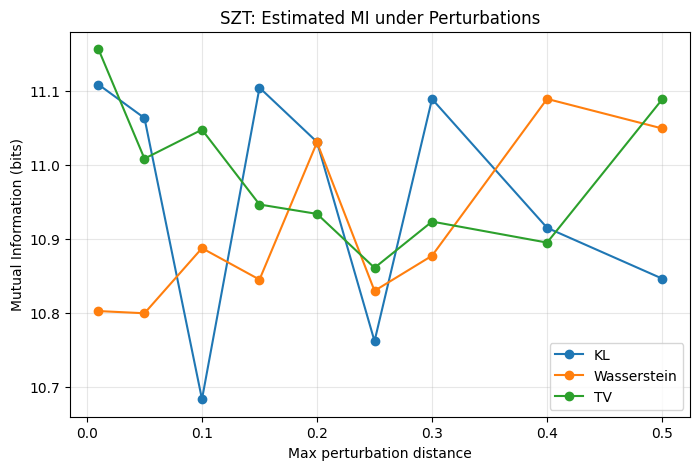


=== MNIST_L3 — Perturbation Results ===

-- KL perturbation --
 max_distance   I_nats   I_bits
         0.01 6.712991 9.684799
         0.05 6.738040 9.720937
         0.10 6.695603 9.659713
         0.15 6.573870 9.484090
         0.20 6.754396 9.744534
         0.25 6.640544 9.580280
         0.30 6.514957 9.399096
         0.40 6.697442 9.662367
         0.50 6.656560 9.603386

-- Wasserstein perturbation --
 max_distance   I_nats   I_bits
         0.01 6.702605 9.669815
         0.05 6.605464 9.529671
         0.10 6.629794 9.564771
         0.15 6.839719 9.867629
         0.20 6.675287 9.630403
         0.25 6.659807 9.608071
         0.30 6.620128 9.550825
         0.40 6.461971 9.322653
         0.50 6.691590 9.653924

-- TV perturbation --
 max_distance   I_nats    I_bits
         0.01 6.737860  9.720677
         0.05 6.619578  9.550032
         0.10 6.721497  9.697071
         0.15 6.769263  9.765982
         0.20 6.579233  9.491828
         0.25 6.752010  9.741092
         0

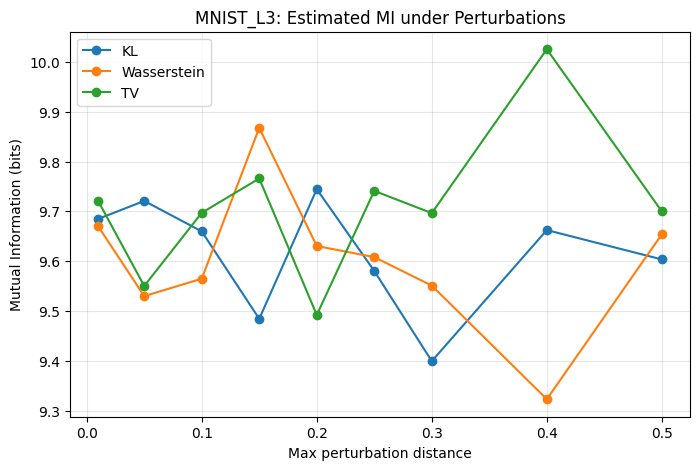

In [18]:
import math
import io
from contextlib import redirect_stdout
import pandas as pd
import matplotlib.pyplot as plt

def _mi_quiet(model, loader, *, layer_tag, preferred_dim, sigma_in, clip, beta_probe, beta_override,
              M, m, n_mc, max_uncond):
    """Call the estimator while silencing internal prints for clean output."""
    buf = io.StringIO()
    with redirect_stdout(buf):
        I = estimate_mi_with_noisy_inputs(
            model,
            loader,
            layer_tag=layer_tag,
            preferred_dim=preferred_dim,
            sigma_in=float(sigma_in),
            M=M, m=m, n_mc=n_mc,
            max_uncond=max_uncond,
            clip=clip,
            beta_probe=beta_probe,
            beta_override=beta_override
        )
    return I

def report_and_plot_perturbations(
    name,
    model,
    loader,
    *,
    distances=('KL', 'Wasserstein', 'TV'),
    max_distances=(0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5),
    layer_tag='auto',
    preferred_dim=None,
    clip=None,
    beta_probe=0.05,
    beta_override=None,
    M=64, m=16, n_mc=16, max_uncond=1000,
    plot=True
):
    rows = []
    for dist in distances:
        for max_d in max_distances:
            # Build perturbed dataset
            all_x, all_y = [], []
            for x, y in loader:
                x = _as_float4d(x)
                if dist == 'KL':
                    perturbed_x = kl_perturb(x, max_d, model)
                elif dist == 'Wasserstein':
                    perturbed_x = wasserstein_perturb(x, max_d, model)
                elif dist == 'TV':
                    perturbed_x = tv_perturb(x, max_d, model)
                else:
                    raise ValueError(f"Unknown distance metric: {dist}")
                all_x.append(perturbed_x)
                all_y.append(y)
            all_x = torch.cat(all_x, dim=0)
            all_y = torch.cat(all_y, dim=0)
            perturbed_dataset = torch.utils.data.TensorDataset(all_x, all_y)
            perturbed_loader = torch.utils.data.DataLoader(perturbed_dataset, batch_size=64, shuffle=True)

            # Run estimator (quiet mode)
            I_hat = _mi_quiet(
                model, perturbed_loader,
                layer_tag=layer_tag, preferred_dim=preferred_dim,
                sigma_in=max_d, clip=clip,
                beta_probe=beta_probe, beta_override=beta_override,
                M=M, m=m, n_mc=n_mc, max_uncond=max_uncond
            )
            rows.append({
                "perturbation": dist,
                "max_distance": float(max_d),
                "I_nats": I_hat,
                "I_bits": I_hat / math.log(2)
            })

    df = pd.DataFrame(rows).sort_values(["perturbation", "max_distance"]).reset_index(drop=True)

    # Print tables per perturbation
    print(f"\n=== {name} — Perturbation Results ===")
    for dist in distances:
        sub = df[df["perturbation"] == dist].reset_index(drop=True)
        print(f"\n-- {dist} perturbation --")
        print(sub[["max_distance", "I_nats", "I_bits"]].to_string(index=False))

    # Plot
    if plot:
        plt.figure(figsize=(8, 5))
        for dist in distances:
            sub = df[df["perturbation"] == dist].sort_values("max_distance")
            plt.plot(sub["max_distance"], sub["I_bits"], marker="o", label=dist)
        plt.title(f"{name}: Estimated MI under Perturbations")
        plt.xlabel("Max perturbation distance")
        plt.ylabel("Mutual Information (bits)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    return df

# ------------------- RUN (only if variables exist) -------------------

# SZT perturbation experiment with plots
if 'model' in globals() and 'train_loader' in globals():
    df_szt_perturb = report_and_plot_perturbations(
        name="SZT",
        model=model,
        loader=train_loader,
        distances=('KL', 'Wasserstein', 'TV'),
        max_distances=(0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5),
        layer_tag='auto',
        preferred_dim=3,
        clip=None,
        beta_probe=0.005,
        beta_override=None,
        M=64, m=16, n_mc=16, max_uncond=2000,
        plot=True
    )

# MNIST perturbation experiment with plots
if 'test_loader' in globals() and ('mnist_noisy' in globals() or 'det_model' in globals()):
    active_mnist_model = mnist_noisy if 'mnist_noisy' in globals() else det_model
    df_mnist_perturb = report_and_plot_perturbations(
        name="MNIST_L3",
        model=active_mnist_model,
        loader=test_loader,
        distances=('KL', 'Wasserstein', 'TV'),
        max_distances=(0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5),
        layer_tag='L3',
        preferred_dim=None,
        clip=(0.0, 1.0),
        beta_probe=0.05,
        beta_override=None,
        M=50, m=16, n_mc=16, max_uncond=800,
        plot=True
    )



=== Running KL perturbations (train set) ===
[SZT-KL] Found layers: ['L1', 'L2', 'L3']

=== SZT-KL — Multi-Layer Perturbation Results ===

### Layer L1 ###

-- KL perturbation --
 max_distance   I_nats    I_bits
         0.00 8.098438 11.683577
         0.01 7.689468 11.093557
         0.02 7.593745 10.955459
         0.03 7.551414 10.894388
         0.04 8.744642 12.615852
         0.05 7.997133 11.537424
         0.06 7.141132 10.302476
         0.07 8.009697 11.555550
         0.08 6.754648  9.744897
         0.09 8.169796 11.786524
         0.10 7.065335 10.193124

### Layer L2 ###

-- KL perturbation --
 max_distance   I_nats    I_bits
         0.00 7.103489 10.248168
         0.01 8.068532 11.640432
         0.02 7.307170 10.542018
         0.03 7.326169 10.569428
         0.04 7.969855 11.498071
         0.05 7.007807 10.110128
         0.06 8.314129 11.994752
         0.07 7.792251 11.241842
         0.08 8.217534 11.855395
         0.09 7.804272 11.259184
         0.10 7.6560

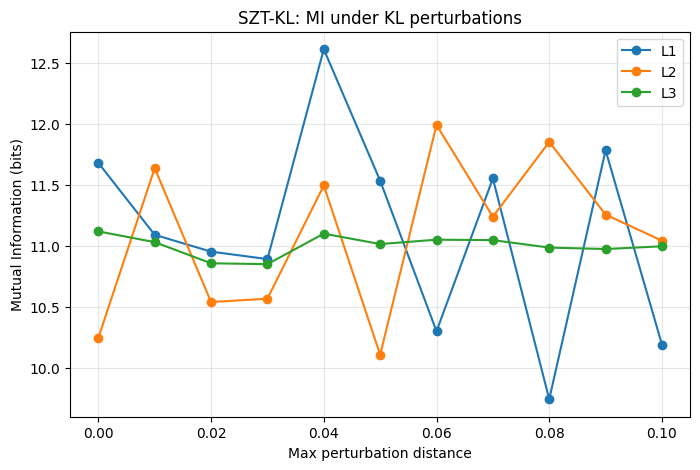


=== Running Wasserstein perturbations (train set) ===
[SZT-Wasserstein] Found layers: ['L1', 'L2', 'L3']


Exception in thread Thread-232 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 37, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/resource

KeyboardInterrupt: 

    c = Client(address, authkey=process.current_process().authkey)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 519, in Client
    c = SocketClient(address)
        ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 647, in SocketClient
    s.connect(address)
FileNotFoundError: [Errno 2] No such file or directory


In [19]:
import math
import io
from contextlib import redirect_stdout
import pandas as pd
import matplotlib.pyplot as plt

def _mi_quiet(model, loader, *, layer_tag, preferred_dim, sigma_in, clip, beta_probe, beta_override,
              M, m, n_mc, max_uncond):
    """Call the estimator while silencing internal prints for clean output."""
    buf = io.StringIO()
    with redirect_stdout(buf):
        I = estimate_mi_with_noisy_inputs(
            model,
            loader,
            layer_tag=layer_tag,
            preferred_dim=preferred_dim,
            sigma_in=float(sigma_in),
            M=M, m=m, n_mc=n_mc,
            max_uncond=max_uncond,
            clip=clip,
            beta_probe=beta_probe,
            beta_override=beta_override
        )
    return I

def discover_layer_tags(model, loader):
    """Run one forward pass and collect available capture tags."""
    x0, _ = next(iter(loader))
    cap = {}
    _ = model(x0.to(next(model.parameters()).device), capture=cap)
    tags = [k.replace("_S", "") for k in cap.keys() if k.endswith("_S")]
    return sorted(set(tags))

def report_and_plot_perturbations_by_layer(
    name,
    model,
    loader,
    *,
    distances=('KL', 'Wasserstein', 'TV'),
    max_distances=(0.01, 0.05, 0.1, 0.2, 0.3, 0.4),
    clip=None,
    beta_probe=0.05,
    beta_override=None,
    M=64, m=16, n_mc=16, max_uncond=1000,
    plot=True
):
    # Find all layer tags
    layer_tags = discover_layer_tags(model, loader)
    print(f"[{name}] Found layers: {layer_tags}")

    results = []
    for layer_tag in layer_tags:
        for dist in distances:
            for max_d in max_distances:
                # Perturb dataset
                all_x, all_y = [], []
                for x, y in loader:
                    x = _as_float4d(x)
                    if dist == 'KL':
                        perturbed_x = kl_perturb(x, max_d, model)
                    elif dist == 'Wasserstein':
                        perturbed_x = wasserstein_perturb(x, max_d, model)
                    elif dist == 'TV':
                        perturbed_x = tv_perturb(x, max_d, model)
                    all_x.append(perturbed_x)
                    all_y.append(y)
                all_x = torch.cat(all_x, dim=0)
                all_y = torch.cat(all_y, dim=0)
                perturbed_dataset = torch.utils.data.TensorDataset(all_x, all_y)
                perturbed_loader = torch.utils.data.DataLoader(perturbed_dataset, batch_size=64, shuffle=True)

                # Estimate MI
                I_hat = _mi_quiet(
                    model, perturbed_loader,
                    layer_tag=layer_tag, preferred_dim=None,
                    sigma_in=max_d, clip=clip,
                    beta_probe=beta_probe, beta_override=beta_override,
                    M=M, m=m, n_mc=n_mc, max_uncond=max_uncond
                )
                results.append({
                    "layer": layer_tag,
                    "perturbation": dist,
                    "max_distance": float(max_d),
                    "I_nats": I_hat,
                    "I_bits": I_hat / math.log(2)
                })

    df = pd.DataFrame(results).sort_values(["layer","perturbation","max_distance"]).reset_index(drop=True)

    # Print tables grouped by layer
    print(f"\n=== {name} — Multi-Layer Perturbation Results ===")
    for layer_tag in layer_tags:
        print(f"\n### Layer {layer_tag} ###")
        for dist in distances:
            sub = df[(df["layer"]==layer_tag) & (df["perturbation"]==dist)].reset_index(drop=True)
            print(f"\n-- {dist} perturbation --")
            print(sub[["max_distance","I_nats","I_bits"]].to_string(index=False))

    # Plots
    if plot:
        for dist in distances:
            plt.figure(figsize=(8,5))
            for layer_tag in layer_tags:
                sub = df[(df["perturbation"]==dist) & (df["layer"]==layer_tag)]
                plt.plot(sub["max_distance"], sub["I_bits"], marker="o", label=layer_tag)
            plt.title(f"{name}: MI under {dist} perturbations")
            plt.xlabel("Max perturbation distance")
            plt.ylabel("Mutual Information (bits)")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

    return df

# ------------------- RUN (only if variables exist) -------------------
# MAX_DS = tuple(round(x, 2) for x in np.arange(0.00, 0.401, 0.01))
# print("max_distances =", MAX_DS)

# if 'model' in globals() and 'train_loader' in globals():
#     df_szt_layers = report_and_plot_perturbations_by_layer(
#         name="SZT",
#         model=model,
#         loader=train_loader,
#         distances=('KL','Wasserstein','TV'),
#         max_distances=MAX_DS,
#         clip=None,
#         beta_probe=0.005,
#         beta_override=None,
#         M=64, m=16, n_mc=16, max_uncond=2000,
#         plot=True
#     )

# if 'test_loader' in globals() and ('mnist_noisy' in globals() or 'det_model' in globals()):
#     active_mnist_model = mnist_noisy if 'mnist_noisy' in globals() else det_model
#     df_mnist_layers = report_and_plot_perturbations_by_layer(
#         name="MNIST",
#         model=active_mnist_model,
#         loader=test_loader,
#         distances=('KL','Wasserstein','TV'),
#         max_distances=MAX_DS,
#         clip=(0.0,1.0),
#         beta_probe=0.05,
#         beta_override=None,
#         M=50, m=16, n_mc=16, max_uncond=800,
#         plot=True
#     )

# Define separate max_distance ranges for each perturbation type
DISTANCE_MAX_MAP = {
    "KL": tuple(round(x, 3) for x in np.arange(0.0, 0.101, 0.01)),          # finer scale for KL
    "Wasserstein": tuple(round(x, 3) for x in np.arange(0.0, 1.01, 0.05)),  # broader scale
    "TV": tuple(round(x, 3) for x in np.arange(0.0, 0.401, 0.01)),          # capped at 0.4
}

# Run for training loader
if 'model' in globals() and 'train_loader' in globals():
    dfs = {}
    for dist, max_ds in DISTANCE_MAX_MAP.items():
        print(f"\n=== Running {dist} perturbations (train set) ===")
        dfs[dist] = report_and_plot_perturbations_by_layer(
            name=f"SZT-{dist}",
            model=model,
            loader=train_loader,
            distances=(dist,),       # run one distance at a time
            max_distances=max_ds,
            clip=None,
            beta_probe=0.005,
            beta_override=None,
            M=64, m=16, n_mc=16, max_uncond=2000,
            plot=True
        )

# Run for test loader (MNIST models)
if 'test_loader' in globals() and ('mnist_noisy' in globals() or 'det_model' in globals()):
    active_mnist_model = mnist_noisy if 'mnist_noisy' in globals() else det_model
    dfs_mnist = {}
    for dist, max_ds in DISTANCE_MAX_MAP.items():
        print(f"\n=== Running {dist} perturbations (MNIST test set) ===")
        dfs_mnist[dist] = report_and_plot_perturbations_by_layer(
            name=f"MNIST-{dist}",
            model=active_mnist_model,
            loader=test_loader,
            distances=(dist,),
            max_distances=max_ds,
            clip=(0.0,1.0),
            beta_probe=0.05,
            beta_override=None,
            M=50, m=16, n_mc=16, max_uncond=800,
            plot=True
        )



In [23]:
def plot_mi_over_epochs_by_distance(
    name,
    model,
    loader,
    distance,
    max_distances,
    n_epochs=5,
    clip=None,
    beta_probe=0.05,
    beta_override=None,
    M=64, m=16, n_mc=16, max_uncond=1000,
):
    """Track MI over epochs, grouped by max_distance (each plot shows all layers)."""
    layer_tags = discover_layer_tags(model, loader)
    print(f"[{name}] Found layers: {layer_tags}")

    results = []

    for epoch in range(1, n_epochs + 1):
        print(f"\n=== Epoch {epoch}/{n_epochs} ===")
        for max_d in max_distances:
            # Perturb dataset
            all_x, all_y = [], []
            for x, y in loader:
                x = _as_float4d(x)
                if distance == 'KL':
                    perturbed_x = kl_perturb(x, max_d, model)
                elif distance == 'Wasserstein':
                    perturbed_x = wasserstein_perturb(x, max_d, model)
                elif distance == 'TV':
                    perturbed_x = tv_perturb(x, max_d, model)
                all_x.append(perturbed_x)
                all_y.append(y)
            all_x = torch.cat(all_x, dim=0)
            all_y = torch.cat(all_y, dim=0)
            perturbed_dataset = torch.utils.data.TensorDataset(all_x, all_y)
            perturbed_loader = torch.utils.data.DataLoader(perturbed_dataset, batch_size=64, shuffle=True)

            # Estimate MI for each layer
            for layer_tag in layer_tags:
                I_hat = _mi_quiet(
                    model, perturbed_loader,
                    layer_tag=layer_tag, preferred_dim=None,
                    sigma_in=max_d, clip=clip,
                    beta_probe=beta_probe, beta_override=beta_override,
                    M=M, m=m, n_mc=n_mc, max_uncond=max_uncond
                )
                results.append({
                    "epoch": epoch,
                    "layer": layer_tag,
                    "perturbation": distance,
                    "max_distance": float(max_d),
                    "I_nats": I_hat,
                    "I_bits": I_hat / math.log(2)
                })

    df = pd.DataFrame(results)

    # ---- Plot: one plot per max_distance ----
    for max_d in sorted(max_distances):
        plt.figure(figsize=(8,5))
        for layer_tag in layer_tags:
            sub = df[(df["layer"]==layer_tag) & (df["max_distance"]==max_d)]
            plt.plot(sub["epoch"], sub["I_bits"], marker="o", label=layer_tag)
        plt.title(f"{name} — MI over epochs\n{distance} perturbation, max_distance={max_d}")
        plt.xlabel("Epoch")
        plt.ylabel("Mutual Information (bits)")
        plt.legend(title="Layer")
        plt.grid(True, alpha=0.3)
        plt.show()

    return df


[SZT] Found layers: ['L1', 'L2', 'L3']

=== Epoch 1/100 ===

=== Epoch 2/100 ===

=== Epoch 3/100 ===

=== Epoch 4/100 ===

=== Epoch 5/100 ===

=== Epoch 6/100 ===

=== Epoch 7/100 ===

=== Epoch 8/100 ===

=== Epoch 9/100 ===

=== Epoch 10/100 ===

=== Epoch 11/100 ===

=== Epoch 12/100 ===

=== Epoch 13/100 ===

=== Epoch 14/100 ===

=== Epoch 15/100 ===

=== Epoch 16/100 ===

=== Epoch 17/100 ===

=== Epoch 18/100 ===

=== Epoch 19/100 ===

=== Epoch 20/100 ===

=== Epoch 21/100 ===

=== Epoch 22/100 ===

=== Epoch 23/100 ===

=== Epoch 24/100 ===

=== Epoch 25/100 ===

=== Epoch 26/100 ===

=== Epoch 27/100 ===

=== Epoch 28/100 ===

=== Epoch 29/100 ===

=== Epoch 30/100 ===

=== Epoch 31/100 ===

=== Epoch 32/100 ===

=== Epoch 33/100 ===

=== Epoch 34/100 ===

=== Epoch 35/100 ===

=== Epoch 36/100 ===

=== Epoch 37/100 ===

=== Epoch 38/100 ===

=== Epoch 39/100 ===

=== Epoch 40/100 ===

=== Epoch 41/100 ===

=== Epoch 42/100 ===

=== Epoch 43/100 ===

=== Epoch 44/100 ===

=

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c38497ada80><function _MultiProcessingDataLoaderIter.__del__ at 0x7c38497ada80>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
if w.is_alive():
     if w.is_alive(): 
          ^ ^ ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3


=== Epoch 72/100 ===

=== Epoch 73/100 ===

=== Epoch 74/100 ===

=== Epoch 75/100 ===

=== Epoch 76/100 ===

=== Epoch 77/100 ===

=== Epoch 78/100 ===

=== Epoch 79/100 ===

=== Epoch 80/100 ===

=== Epoch 81/100 ===

=== Epoch 82/100 ===

=== Epoch 83/100 ===

=== Epoch 84/100 ===

=== Epoch 85/100 ===

=== Epoch 86/100 ===

=== Epoch 87/100 ===

=== Epoch 88/100 ===

=== Epoch 89/100 ===

=== Epoch 90/100 ===

=== Epoch 91/100 ===

=== Epoch 92/100 ===

=== Epoch 93/100 ===

=== Epoch 94/100 ===

=== Epoch 95/100 ===

=== Epoch 96/100 ===

=== Epoch 97/100 ===

=== Epoch 98/100 ===

=== Epoch 99/100 ===

=== Epoch 100/100 ===


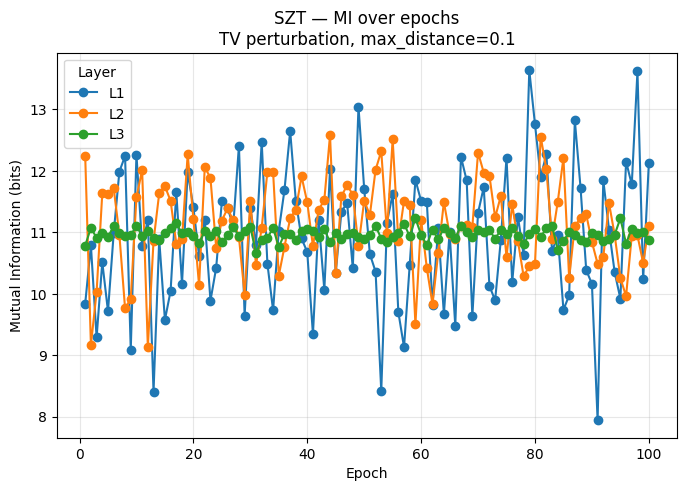

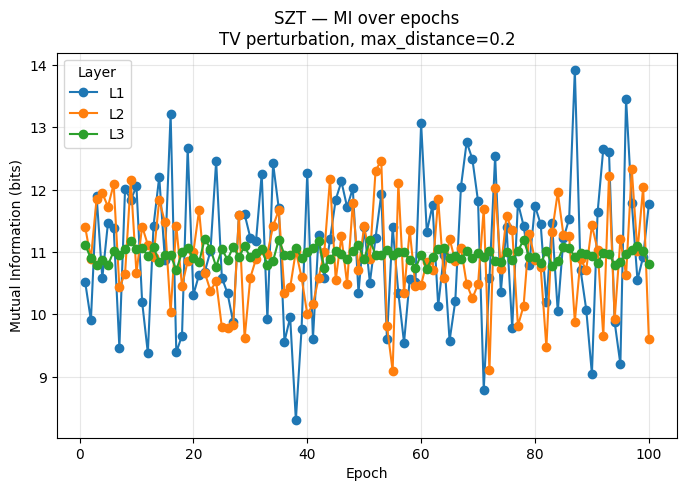

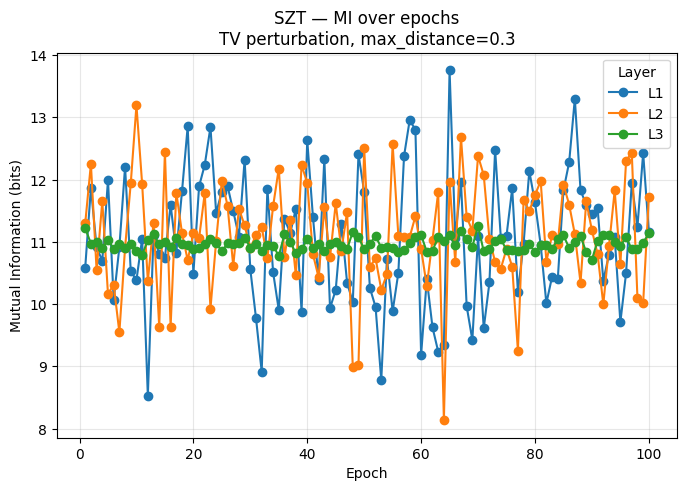

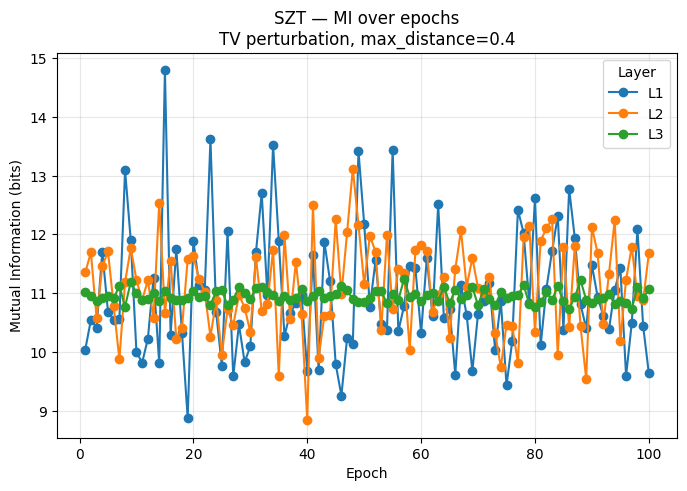

In [27]:
if 'model' in globals() and 'train_loader' in globals():
    df_tv = plot_mi_over_epochs_by_distance(
        name="SZT",
        model=model,
        loader=train_loader,
        distance="TV",
        max_distances=(0.1, 0.2, 0.3, 0.4),
        n_epochs=100,
        clip=None,
        beta_probe=0.005,
        M=64, m=16, n_mc=16, max_uncond=2000,
    )


[SZT] Found layers: ['L1', 'L2', 'L3']

=== Epoch 1/100 ===

=== Epoch 2/100 ===

=== Epoch 3/100 ===

=== Epoch 4/100 ===

=== Epoch 5/100 ===

=== Epoch 6/100 ===

=== Epoch 7/100 ===

=== Epoch 8/100 ===

=== Epoch 9/100 ===

=== Epoch 10/100 ===

=== Epoch 11/100 ===

=== Epoch 12/100 ===

=== Epoch 13/100 ===

=== Epoch 14/100 ===

=== Epoch 15/100 ===

=== Epoch 16/100 ===

=== Epoch 17/100 ===

=== Epoch 18/100 ===

=== Epoch 19/100 ===

=== Epoch 20/100 ===

=== Epoch 21/100 ===

=== Epoch 22/100 ===

=== Epoch 23/100 ===

=== Epoch 24/100 ===

=== Epoch 25/100 ===

=== Epoch 26/100 ===

=== Epoch 27/100 ===

=== Epoch 28/100 ===

=== Epoch 29/100 ===

=== Epoch 30/100 ===

=== Epoch 31/100 ===

=== Epoch 32/100 ===

=== Epoch 33/100 ===

=== Epoch 34/100 ===

=== Epoch 35/100 ===

=== Epoch 36/100 ===

=== Epoch 37/100 ===

=== Epoch 38/100 ===

=== Epoch 39/100 ===

=== Epoch 40/100 ===

=== Epoch 41/100 ===

=== Epoch 42/100 ===

=== Epoch 43/100 ===

=== Epoch 44/100 ===

=

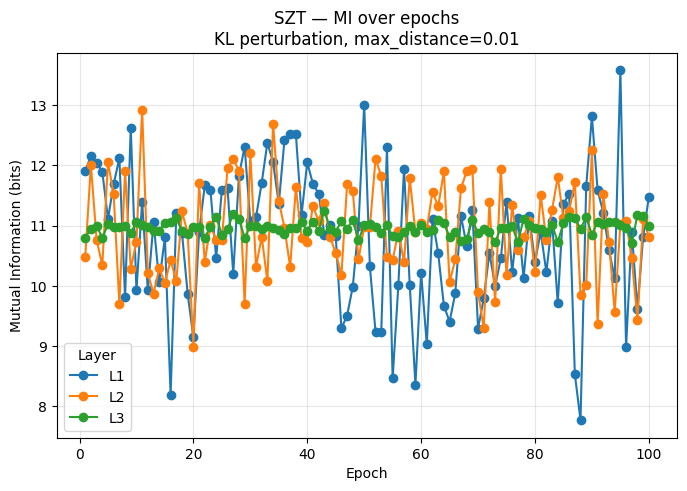

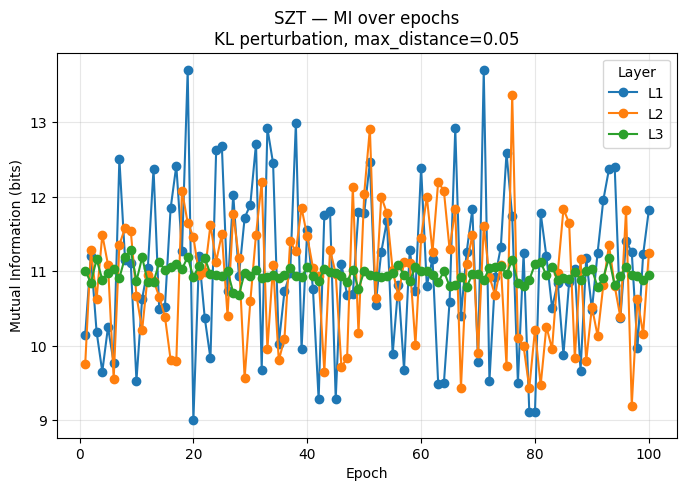

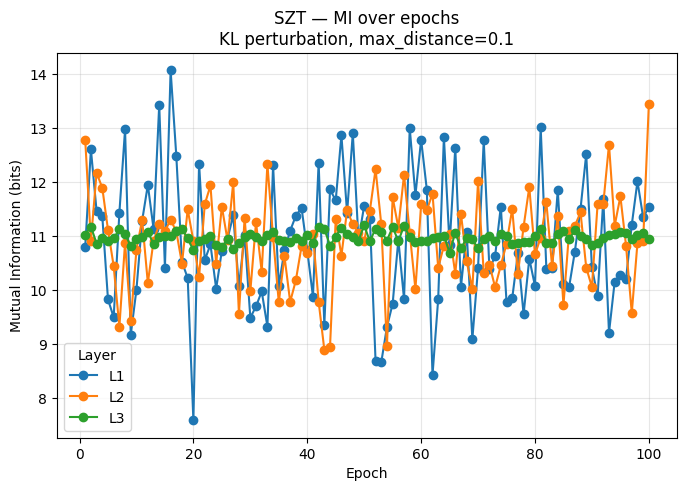

In [28]:
# --- KL Perturbation (fine scale up to 0.1) ---
if 'model' in globals() and 'train_loader' in globals():
    df_kl = plot_mi_over_epochs_by_distance(
        name="SZT",
        model=model,
        loader=train_loader,
        distance="KL",
        max_distances=(0.01, 0.05, 0.1),
        n_epochs=100,
        clip=None,
        beta_probe=0.005,
        M=64, m=16, n_mc=16, max_uncond=2000,
    )

[SZT] Found layers: ['L1', 'L2', 'L3']

=== Epoch 1/100 ===

=== Epoch 2/100 ===

=== Epoch 3/100 ===

=== Epoch 4/100 ===

=== Epoch 5/100 ===

=== Epoch 6/100 ===

=== Epoch 7/100 ===

=== Epoch 8/100 ===

=== Epoch 9/100 ===

=== Epoch 10/100 ===

=== Epoch 11/100 ===

=== Epoch 12/100 ===

=== Epoch 13/100 ===

=== Epoch 14/100 ===

=== Epoch 15/100 ===

=== Epoch 16/100 ===

=== Epoch 17/100 ===

=== Epoch 18/100 ===

=== Epoch 19/100 ===

=== Epoch 20/100 ===

=== Epoch 21/100 ===

=== Epoch 22/100 ===

=== Epoch 23/100 ===

=== Epoch 24/100 ===

=== Epoch 25/100 ===

=== Epoch 26/100 ===

=== Epoch 27/100 ===

=== Epoch 28/100 ===

=== Epoch 29/100 ===

=== Epoch 30/100 ===

=== Epoch 31/100 ===

=== Epoch 32/100 ===

=== Epoch 33/100 ===

=== Epoch 34/100 ===

=== Epoch 35/100 ===

=== Epoch 36/100 ===

=== Epoch 37/100 ===

=== Epoch 38/100 ===

=== Epoch 39/100 ===

=== Epoch 40/100 ===

=== Epoch 41/100 ===

=== Epoch 42/100 ===

=== Epoch 43/100 ===

=== Epoch 44/100 ===

=

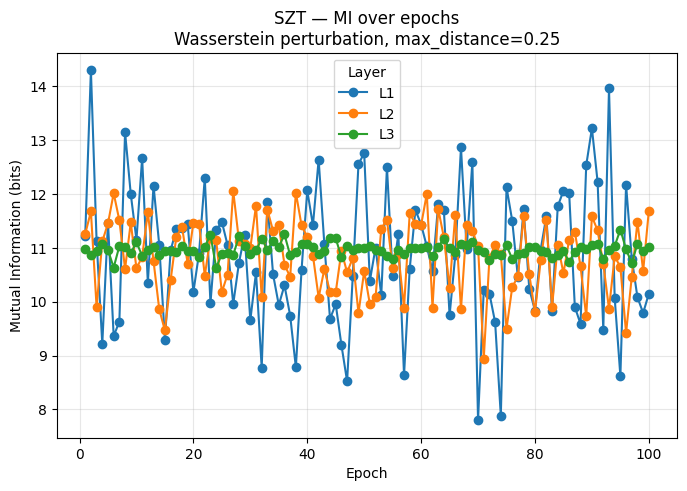

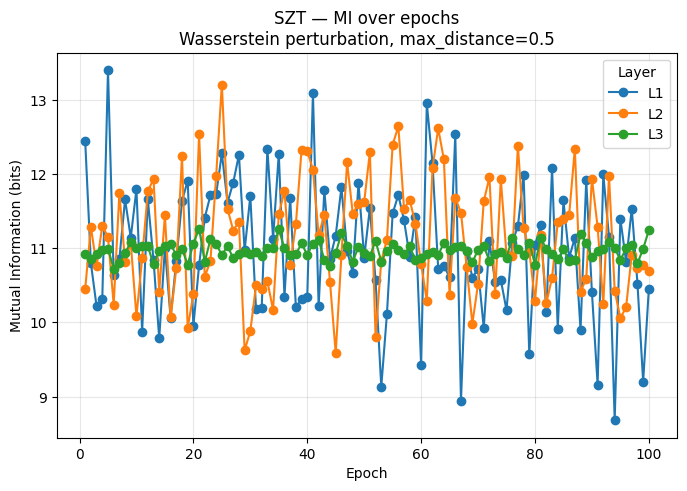

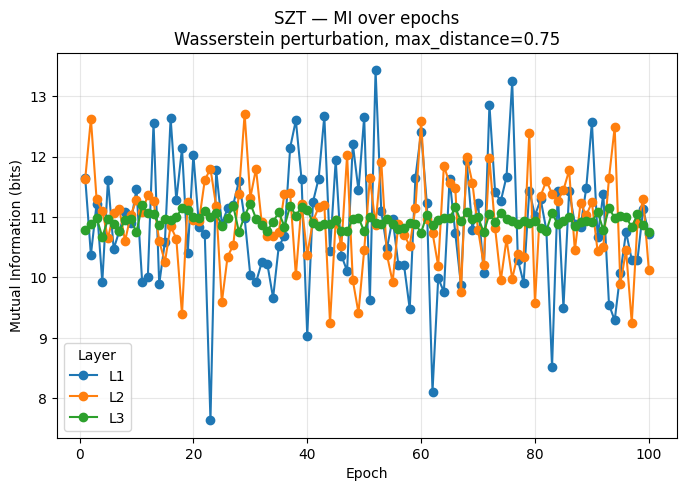

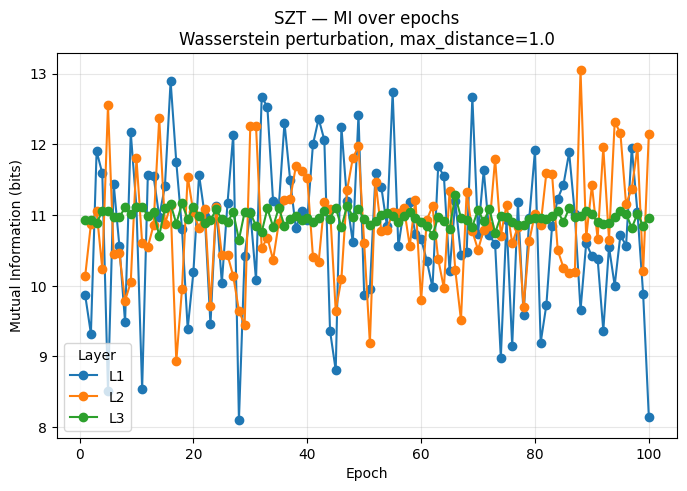

In [29]:
# --- Wasserstein Perturbation (broader scale up to 1.0) ---
if 'model' in globals() and 'train_loader' in globals():
    df_wass = plot_mi_over_epochs_by_distance(
        name="SZT",
        model=model,
        loader=train_loader,
        distance="Wasserstein",
        max_distances=(0.25, 0.5, 0.75, 1.0),
        n_epochs=100,
        clip=None,
        beta_probe=0.005,
        M=64, m=16, n_mc=16, max_uncond=2000,
    )